In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np
db = mysql.connector.connect( host = "localhost",
                              username = "root",
                              password = "Aaditya@2002",
                              database = "ecommerce")

cur = db.cursor()


# 1. list all the unique cities where customers are located.

In [28]:
query = """ select distinct customer_city from customers"""

cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [8]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)= 2017"""

cur.execute(query)
data =cur.fetchall()
"Total order placed in 2017 are", data[0][0]

('Total order placed in 2017 are', 45101)

# 3. Find the total sales per category.

In [16]:
query = """ select products.product_category, 
round(sum(payments.payment_value),2)
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by products.product_category"""

cur.execute(query)
data =cur.fetchall()

df= pd.DataFrame(data, columns = [ "Category", "Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [20]:

query = """ select sum( case when payment_installments >= 1 then 1 else 0 end) / count(*) * 100 from payments"""

cur.execute(query)
data =cur.fetchall()
" the percentage of orders that were paid in installments :-", data[0][0]


(' the percentage of orders that were paid in installments :-',
 Decimal('99.9981'))

# 5.Count the number of customers from each state. 


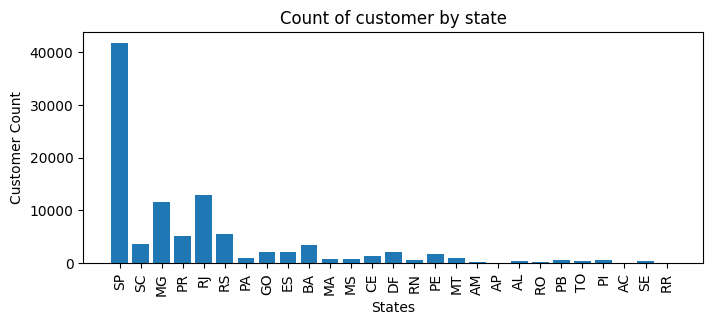

In [53]:
query = """ select customer_state, count(customer_id)
from customers
group by customer_state"""

cur.execute(query)
data =cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])

plt.figure(figsize =(8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Customer Count")
plt.title("Count of customer by state")
plt.show()
                                  

# 1. Calculate the number of orders per month in 2018.


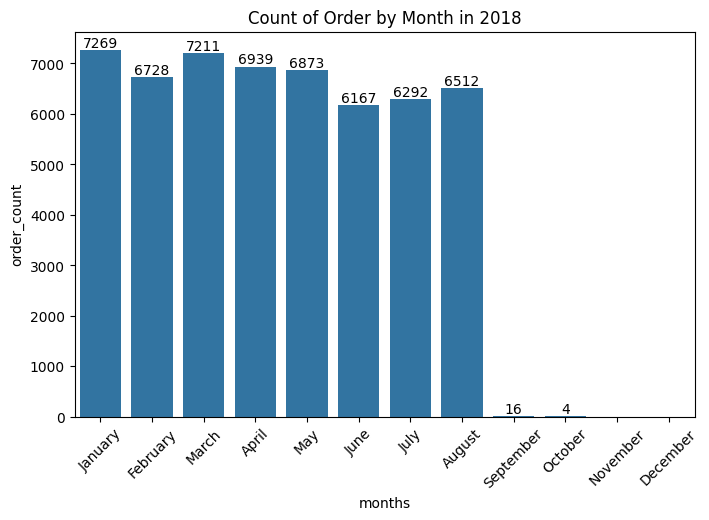

In [55]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(query)
data =cur.fetchall()

plt.figure(figsize =(8,5))
df = pd.DataFrame(data, columns= ["months","order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August","September","October","November","December" ]

ax= sns.barplot(x = df["months"], y=  df["order_count"], data =df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Order by Month in 2018")
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [69]:
query = """ with count_per_order as 
( select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city , round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc;
"""

cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data, columns = ["customer city", "average orders"])
df.head(10)

,customer city,average orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [79]:
query = """ select products.product_category as category, 
round((sum(payments.payment_value) / (select sum(payment_value) from payments)) *100 , 2 ) as sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by products.product_category
order by sales_percentage desc"""

cur.execute(query)
data =cur.fetchall()

df= pd.DataFrame(data, columns = [ "Category", "Sales Percentage "])
df.head(10)

,Category,Sales Percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [89]:
query = """ select products.product_category, count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)
data =cur.fetchall()

df= pd.DataFrame(data, columns = [ "Category", "Count", "Price" ])
arr1 = df['Count']
arr2 = df['Price']

a = np.corrcoef(arr1, arr2)
print("The correlation between price and number of times a product has been purchased is", a[0][1]) 

The correlation between price and number of times a product has been purchased is -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

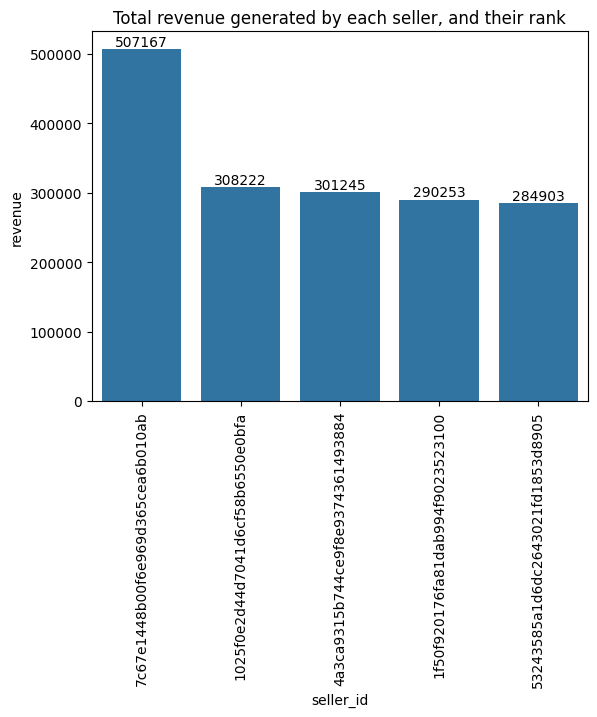

In [96]:
query = """ select *,dense_rank() over(order by revenue desc ) as rn from
(select order_items.seller_id , sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data, columns =["seller_id", "revenue", "rank"])
df = df.head()
ax =sns.barplot(x = "seller_id", y = "revenue", data =df)
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("Total revenue generated by each seller, and their rank")
plt.show()

# 1. Calculate the moving average of order values for each customer over their order history.


In [102]:
query = """ select customer_id , order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row ) as mov_avg
from 
(select  orders.customer_id, orders.order_purchase_timestamp, payments.payment_value
as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""

cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data, columns =["customer_id","order_purchase_timestamp", "payment_avg", "payment" ])
df

,customer_id,order_purchase_timestamp,payment_avg,payment
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 2. Calculate the cumulative sales per month for each year.

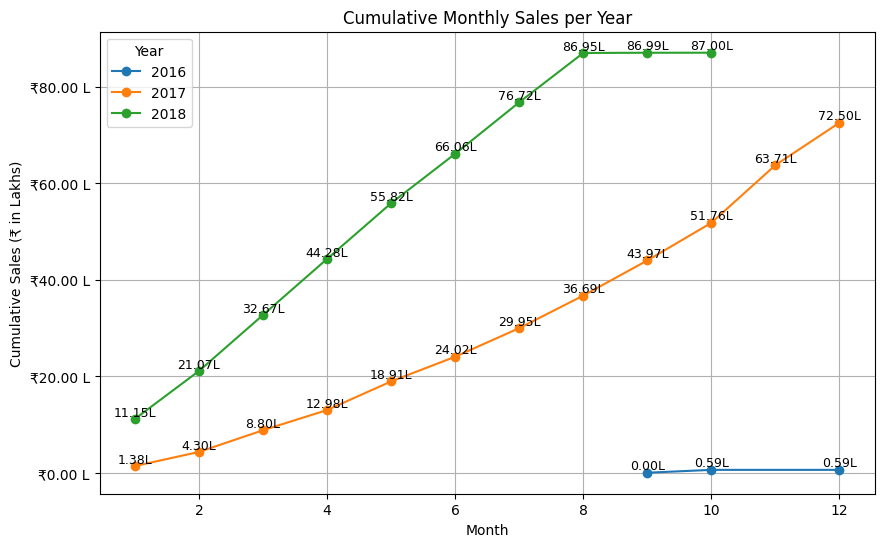

In [111]:
query = """ SELECT
    YEAR(o.order_purchase_timestamp) AS years,
    MONTH(o.order_purchase_timestamp) AS months,
    ROUND(SUM(p.payment_value), 2) AS monthly_sales,
    ROUND(
        SUM(SUM(p.payment_value)) OVER (
            PARTITION BY YEAR(o.order_purchase_timestamp)
            ORDER BY MONTH(o.order_purchase_timestamp)
        ),
        2
    ) AS cumulative_sales
FROM orders o
JOIN payments p
    ON o.order_id = p.order_id
GROUP BY years, months
ORDER BY years, months;
"""

cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(
    data,
    columns=["Year", "Month", "Monthly_Sales", "Cumulative_Sales"]
)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def format_lakhs(x, pos):
    return f'₹{x/1e5:.2f} L'

plt.figure(figsize=(10, 6))

for year in df["Year"].unique():
    year_data = df[df["Year"] == year]

    plt.plot(
        year_data["Month"],
        year_data["Cumulative_Sales"],
        marker='o',
        label=str(year)
    )
                                                        # I used ChatGPT to create this graph
    
    # 🔹 Add value labels
    for x, y in zip(year_data["Month"], year_data["Cumulative_Sales"]):
        plt.text(
            x, y,
            f'{y/1e5:.2f}L',
            fontsize=9,
            ha='center',
            va='bottom'
        )

plt.xlabel("Month")
plt.ylabel("Cumulative Sales (₹ in Lakhs)")
plt.title("Cumulative Monthly Sales per Year")

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_lakhs))
plt.legend(title="Year")
plt.grid(True)
plt.show()

# 3. Calculate the year-over-year growth rate of total sales.


In [121]:
query= """with a as ( select year (orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id = payments.order_id
group by years 
order by years)

select years,payment ,lag(payment, 1) over (order by years),  ((payment - (lag(payment, 1) over (order by years)))/
(lag(payment, 1) over (order by years))) * 100  as previous_year from a

"""

cur.execute(query)
data = cur.fetchall()

df_yoy = pd.DataFrame(
    data,
    columns=["Year", "Total_Sales"," previous_year" , "YOY Growth %" ]
)

df_yoy

,Year,Total_Sales,previous_year,YOY Growth %
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.703761
2,2018,8699763.05,7249746.73,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [124]:
query= """ WITH first_purchase AS (
    SELECT
        customer_id,
        MIN(order_purchase_timestamp) AS first_order_date
    FROM orders
    GROUP BY customer_id
),

repeat_customers AS (
    SELECT DISTINCT
        o.customer_id
    FROM orders o
    JOIN first_purchase fp
        ON o.customer_id = fp.customer_id
    WHERE o.order_purchase_timestamp > fp.first_order_date
      AND o.order_purchase_timestamp <= DATE_ADD(fp.first_order_date, INTERVAL 6 MONTH)
)

SELECT
    ROUND(
        COUNT(DISTINCT rc.customer_id) * 100.0
        / COUNT(DISTINCT fp.customer_id),
        2
    ) AS retention_rate_percentage
FROM first_purchase fp
LEFT JOIN repeat_customers rc
    ON fp.customer_id = rc.customer_id;
"""

cur.execute(query)
data = cur.fetchall()

df_retention = pd.DataFrame(
    data,
    columns=["Retention_Rate_%"]
)

df_retention


,Retention_Rate_%
0,0.00


# 5. Identify the top 3 customers who spent the most money in each year.

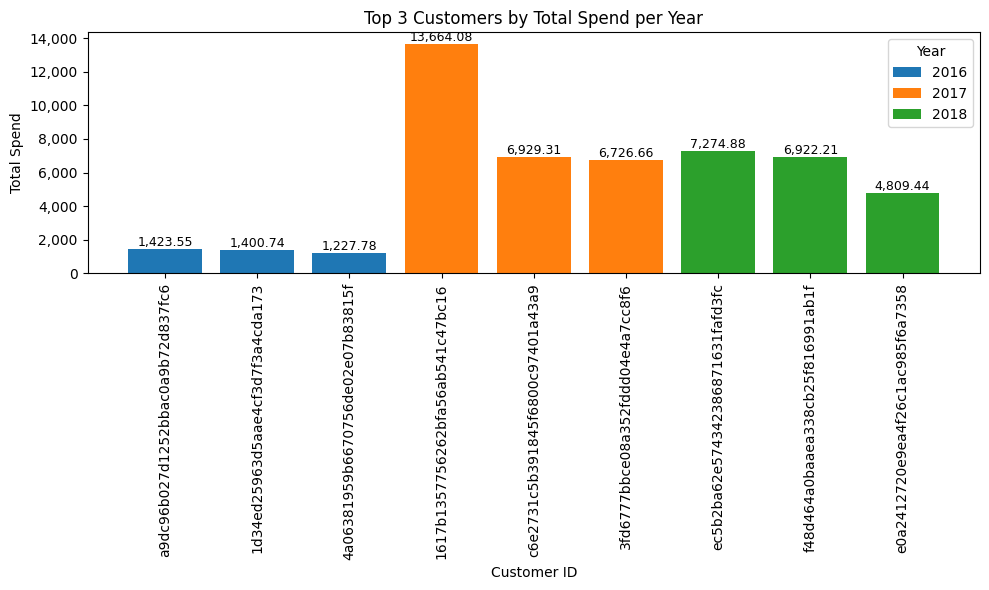

In [140]:
query = '''WITH customer_yearly_spend AS (
    SELECT
        YEAR(o.order_purchase_timestamp) AS year,
        o.customer_id,
        ROUND(SUM(p.payment_value), 2) AS total_spent
    FROM orders o
    JOIN payments p
        ON o.order_id = p.order_id
    GROUP BY
        year,
        o.customer_id
),

ranked_customers AS (
    SELECT
        year,
        customer_id,
        total_spent,
        DENSE_RANK() OVER (
            PARTITION BY year
            ORDER BY total_spent DESC
        ) AS rank_in_year
    FROM customer_yearly_spend
)

SELECT
    year,
    customer_id,
    total_spent,
    rank_in_year
FROM ranked_customers
WHERE rank_in_year <= 3
ORDER BY year, rank_in_year'''



import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Formatter for exact values with commas
def format_exact(x, pos):
    return f'{x:,.0f}'

plt.figure(figsize=(10, 6))

for year in df_top_customers["Year"].unique():
    year_data = df_top_customers[df_top_customers["Year"] == year]

    bars = plt.bar(
        year_data["Customer_ID"],
        year_data["Total_Spent"],
        label=str(year)
    )

                                                # I used Chat GPT to create this graph
    
    # 🔹 Exact value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:,.2f}',   # 👈 exact amount
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.xlabel("Customer ID")
plt.ylabel("Total Spend")
plt.title("Top 3 Customers by Total Spend per Year")
plt.xticks(rotation=90)

# Exact values on Y-axis as well
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_exact))

plt.legend(title="Year")
plt.tight_layout()
plt.show()


